# Topic Models

As you've likely realized by this point in the book, there is an abundance of information available online suited to social science research. The breadth of available data means there's more information out there than any individual researcher--or even teams of researchers--would be able to efficiently analyze without the assistance of some additional tools. 

Luckily, topic modeling allows us to quickly and systematically analyze vast quantities of unstructured text. With topic modelling, we are able to uncover some of the more abstract, underlying themes aross large collections of text without putting in the hours of manpower necessary to read through the texts at a human pace. 

This lesson will go over what, exactly, topic modeling does, walk through how to run Latent Dirichlet allocation (LDA) topic models in Python, and introduce a number of fit statistics to help us better understand the topic models we'll be generating. We'll end with a discussion of several useful visualization tools for topic modeling. 

# What is Topic Modeling?


As a form of unsupervised machine learning, *topic modeling* allows for the classification of large collections of textual documents into natural groups, without the need for extensive human supervision. Employed in text mining and natural language processing, topic models can uncover the hidden, or *latent*, meanings of language patterns within texts.  


> In text mining, we often have collections of documents, such as blog posts or news articles, that we’d like to divide into natural groups so that we can understand them separately. Topic modeling is a method for unsupervised classification of such documents, similar to clustering on numeric data, which finds natural groups of items even when we’re not sure what we’re looking for.

[Source](https://www.tidytextmining.com/topicmodeling.html)


## Setup

In addition to `matplotlib inline` and `pandas`, we'll also be importing `CountVectorizer` from [scikit-learn](https://scikit-learn.org/stable/), a machine learning library for Python. We'll discuss the role of `CountVectorizer` in topic modeling in more detail later in the chapter. 

We'll also want to use `pandas` to increase our maximum column width to 120 characters, over the default 50-character column width. This will help us more easily glance over text in the dataframe. 



In [1]:
%matplotlib inline

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer


pd.set_option('display.max_colwidth', 120)

In this chapter we'll be looking at [transcriptions](https://www.kaggle.com/unitednations/un-general-debates) of United Nations General Debates, from 1970 to 2016.

In [2]:
un_df = pd.read_json('data/un-general-debates.json')
print(len(un_df))

ValueError: Expected object or value

With 7,507 complete transcriptions of UN members' statements to work with, this is an ideal dataset to use as we begin playing around with topic models. 

Let's look at a small random sample of 5 texts from the dataframe to get a feel for what we're dealing with:

In [108]:
un_df.sample(5)

,country_code,speech_text,speech_year
1716,SWZ,﻿It is an immense pleasure for me\nto join other Heads of State and Government at this\nsixty-seventh session of the...,2012
1669,AGO,"﻿On behalf\nof the Government of the Republic of Angola, I avail\nmyself of this opportunity to congratulate Mr. Vuk...",2012
1416,NIC,﻿Allow me to begin by congratulating the President on his\nelection to preside over the Assembly this session. We ar...,1996
6092,LCA,"Humanity, our greatest\nconcern, is the reason why we are gathered here today.\nHumanity stands at a defining moment...",2000
3073,BEL,"Mr. President, I hope that you will convey to the President of the Assembly that we are extremely honored at his ele...",1976


### Topic Modeling Exercise 1


Take a look at the text of the UN speeches. When delivering an address, what are the different topics that are covered? Make a list of four topics and provide three example words from each topic.




![](images/lda.jpg)

## Latent Dirichlet allocation (LDA) 

We'll narrow our focus for the time being to one particular form of topic modeling, *Latent Dirichlet allocation*, or *LDA* for short. With LDA topic modeling, we'll be able to treat every document in our corpus as a mixture of topics. Each document in our corpus can contain words associated with any number of topics in varying proportions. At the same time, each topic can be treated as a mixture of words. Any given word can be associated with any number of topics. Considering our documents and topics as these sorts of "mixtures" helps us to mimic the thematic subtleties inherent in natural language.


> Latent Dirichlet allocation (LDA) is a particularly popular method for fitting a topic model. It treats each document as a mixture of topics, and each topic as a mixture of words.  > This allows documents to “overlap” each other in terms of content, rather than being separated into discrete groups, in a way that mirrors typical use of natural language.
Latent Dirichlet allocation is one of the most common algorithms for topic modeling. Without diving into the math behind the model, we can understand it as being guided by two principles.
> * **Every document is a mixture of topics.** We imagine that each document may contain words from several topics in particular proportions. For example, in a two-topic model we could say “Document 1 is 90% topic A and 10% topic B, while Document 2 is 30% topic A and 70% topic B.”
> * **Every topic is a mixture of words.** For example, we could imagine a two-topic model of American news, with one topic for “politics” and one for “entertainment.” The most common words in the politics topic might be “President”, “Congress”, and “government”, while the entertainment topic may be made up of words such as “movies”, “television”, and “actor”. Importantly, words can be shared between topics; a word like “budget” might appear in both equally.

> LDA is a mathematical method for estimating both of these at the same time: finding the mixture of words that is associated with each topic, while also determining the mixture of topics that describes each document. There are a number of existing implementations of this algorithm, and we’ll explore one of them in depth.

[Source](https://www.tidytextmining.com/topicmodeling.html#latent-dirichlet-allocation)

![](images/lda.jpg)

We can import `LatentDirichletAllocation` from scikit-learn to run our own LDA topic models in Python. 

In [105]:
from sklearn.decomposition import LatentDirichletAllocation

### Converting Documents to Vectors

In order to run our topic models, we'll need to convert each document in the corpus into a fixed-length *vector*. We can accomplish this using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?highlight=vectorizer#sklearn.feature_extraction.text.CountVectorizer) function we imported earlier in the chapter. Using `CountVectorizer`, we'll be able to transform our dataset from a collection of text documents into a matrix of token counts.

`CountVectorizer` can take a number of parameters; while not an exhaustive list, some important parameters are described below. 

#### `CountVectorizer` Parameters

- **lowercase**: Converts all text to lower case. By default, `lowercase` is set to True.


- **ngram_range**: This allows us to restrict the range of n-values for our n-grams. Formatted as a tuple, the first sets the minimum n-value, and the second sets the maximum n-value. By default, `n-gram range` is set to (1,1). (If we leave it alone, we'll only be looking at unigrams.) 


- **stop_words**: We can use this parameter to rule out words that occur 1) too frequently, 2) not frequently enough, and/or 3) fall outside of a threshold term frequency. This can be set the 'english' to use a pre-determined set of stopwords often found in texts written in the English language. We can also provide our own list of stopwords if we so choose. 

> - **max_df**: Allows us to set a maximum threshold on document frequency for our terms incorporated into our vocabulary. By default, `max_df` is set to 1.0. 
> - **min_df**: Allows us to set a minimum threshold on document frequency for our terms incorporated into our vocabulary. By default, `max_df` is set to 1.0. 
> - **max_features**: Allows us to build a vocabulary exclusively from high-frequency terms occuring throughout our corpus. 

For now, let's set our parameters so that we convert all text to lower case, only look at unigrams, only look at terms with a document frequency of .90 or below, use the default 'english' stopwords list, and only consider the top 1,000 terms in our corpus.  

In [112]:
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,1),
                             max_df      = .90,
                             stop_words   = 'english',
                             max_features = 1000)

After setting our parameters, we can `fit` the vectorizer to the `speech_text` key in our UN General Debate dataframe to build a vocabulary out of the raw documents.

*Note*: You'll run into an Attribute Error if the key you plan to fit the vectorizer to contains any missing values. While we don't have to worry about this with our UN dataframe, if you encounter such an error in the future, be sure to [clean your dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#missing-data) before attempting to fit the vectorizer. 

In [113]:
vectorizer.fit(un_df['speech_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

We can use the `len` function, along with `get_feature_names`, to ensure we're dealing with a vocabulary composed of the top 1,000 highest-frequency terms in our corpus. 

In [114]:
len(vectorizer.get_feature_names())

1000

Now we'll want to use the vectorizor to `transform` the raw documents into a document-term matrix. 

In [115]:
un_word_counts = vectorizer.transform(un_df['speech_text'])

### Running the LDA Model

Now that we've vectorized our dataset, we're just about ready to run our first LDA model in Python. Before we do, though, we'll want to set our parameters. Below is some information on the parameters we'll set. 

#### `LatentDirichletAllocation` Parameters

- **n_components**: Sets the number of topics generated. We can set this as high or as low as we like, depending on the size and character of the texts in our corpus. 


- **max_iter**: Sets the maximum number of iterations. By default, `max_iter` is set to 10.


- **n_jobs**: Sets the number of concurrently running processes. When set to -1, we'll use all processors. To use all processors but one, set `n_jobs` to -2. 


- **verbose**: Lets us determine whether or not every step of the process is logged. If > 0, we'll be able to see what's going on with our LDA model through the output in real time. 

In [117]:
lda_model = LatentDirichletAllocation(n_components = 10,
                                      max_iter     = 50,
                                      n_jobs       = -1,
                                      verbose      = 1)

With our parameters set, we can `fit` the LDA model to our document-term matrix of the UN General Debate transcripts.

*Note*: It's going to take a while to work our way through up to 50 iterations. That's alright.

In [118]:
lda_model.fit(un_word_counts)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

Congrats, you've run your first topic model on Python!

## Some fit statistics

While we can intuitively "eyeball" topic quality as a first step, it's hard to do so objectively.  Calculating some fit statistics can help us to evaluate our topics' quality numerically.


`LatentDirichletAllocation` includes a few handy methods for calculating fit statistics:

- **`score()`** lets us calculate the approximate logged likelihood of the model parameters we've set, given our data. The higher this number is, the better our topic fit. 
- **`perplexity()`**, another (normalized) form of logged likelihood, calculates the amount of "surprise" our model experiences if we introduce some previously unseen data. The lower this number is, the better our topic fit.

To learn more about evaluating fit for LDA topic models in Python, see [here](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

In [120]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(un_word_counts))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(un_word_counts))

Log Likelihood:  -36142963.39734339
Perplexity:  685.2293725427917


### Guidelines on topic fit
1. Low perplexity on test data.
    - Remeber that the lower our perplexity score, the better our topic fit to our data.
1. **Topical coherence**
2. Best fit in a classification task.
    - We'll discuss classification tasks in more detail in another chapter. 
3. Extract more and then bin them yourself. 
    - When all else fails, 

In [121]:
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 50, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 1}


## Visualizing Topics

In this section we'll discuss some of the ways we can visualize the topics we've created with our LDA model. 

First, we can import `topic_words` from the `pdtext` package in order to create a easily interpretable matrix of our topics. Below, we'll look at the first 10:

In [198]:
from pdtext.tm import topic_words

topic_words(lda_model, vectorizer).head(10)


,1,2,3,4,5,6,7,8,9,10
Topic 1,developing,south,trade,developed,problems,resources,debt,growth,global,africa
Topic 2,human,today,war,years,time,terrorism,let,rights,future,freedom
Topic 3,peoples,social,government,america,order,republic,american,national,rights,respect
Topic 4,nuclear,weapons,soviet,disarmament,republic,relations,war,arms,treaty,union
Topic 5,global,change,climate,small,sustainable,developing,goals,challenges,island,government
Topic 6,africa,south,independence,peoples,namibia,struggle,african,government,regime,non
Topic 7,israel,arab,palestinian,region,iraq,resolutions,council,lebanon,israeli,middle
Topic 8,human,rights,council,cooperation,process,member,role,important,reform,global
Topic 9,africa,african,government,republic,situation,like,national,mr,conflict,president
Topic 10,problems,operation,government,time,great,human,rights,hope,charter,conference


The [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html) library, a port of the [LDAvis](https://github.com/cpsievert/LDAvis) package for R, provides a variety of tools for interactive topic model visualization. 

In [1]:
pip install pyldavis

`pyLDAvis` is conveniently compatible with `LatentDirichletAllocation` from scikit-learn.

In [25]:
import pyLDAvis
import pyLDAvis.sklearn

We'll also import `pyplot` from matplotlib to allow for the generation of interactive plots in Python. 

In [27]:
import matplotlib.pyplot as plt

Now we'll want to use the `enable_notebook()` function to allow us to display visualizations in our notebook.

In [28]:
pyLDAvis.enable_notebook()

Finally, we can use the `prepare()` function to transform the data from our LDA model into interactive visualizations!

In [29]:
pyLDAvis.sklearn.prepare(lda_model, un_word_counts, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  15.685445
8       0.648955  71.707100       2        1  11.938681
5      71.019684   9.971006       3        1  11.476571
0       3.785981  33.185135       4        1  11.001189
2     -42.666500  -9.222070       5        1  10.038386
3      -3.621689 -43.526516       6        1   9.753630
4      -3.632402  -4.171708       7        1   9.742901
7     -36.584400  35.804413       8        1   7.274697
6      44.391380  50.615383       9        1   7.024011
1      40.235809 -31.591665      10        1   6.064491, topic_info=           Term          Freq         Total Category  logprob  loglift
39       africa  31399.000000  31399.000000  Default  30.0000  30.0000
611     nuclear  22925.000000  22925.000000  Default  29.0000  29.0000
40      african  18214.000000  18214.000000  Default  28.0000  28.0000
780    republic  23371.000000  23371.000000  Default  27.0000  27.0000
921   terrorism  11763.000000  11763.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
484   interests   1881.821461  10638.953929  Topic10  -5.1839   1.0704
845   situation   2351.176662  22625.844439  Topic10  -4.9612   0.5385
876       state   2178.857984  23912.142249  Topic10  -5.0373   0.4071
408  government   2289.452706  37628.622757  Topic10  -4.9878   0.0033
292        east   2024.200303  18718.615344  Topic10  -5.1110   0.5784

[565 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.051096       000
0         4  0.482842       000
0         5  0.030521       000
0         6  0.065156       000
0         7  0.073387       000
...     ...       ...       ...
997      10  0.039706     years
998       1  0.002009  zimbabwe
998       2  0.023700  zimbabwe
998       6  0.965291  zimbabwe
998      10  0.008436  zimbabwe

[3127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 6, 1, 3, 4, 5, 8, 7, 2])

In [197]:
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, un_word_counts, vectorizer, mds='tsne')
#panel

### Topic Modeling Exercise 2

In your group, do 1 and 2 in 10_Topic_Modeling_group



## What documents are associated with what topics?

In [126]:
from pdtext.tm import topic_pred

In [130]:
un_topics = topic_pred(lda_model, un_word_counts, vectorizer)

In [131]:
un_topics

,developing_south_trade,human_today_war,peoples_social_government,nuclear_weapons_soviet,global_change_climate,africa_south_independence,israel_arab_palestinian,human_rights_council,africa_african_government,problems_operation_government
0,0.301417,0.000126,0.000126,0.123103,0.125208,0.098048,0.172829,0.005017,0.078136,0.095991
1,0.270243,0.000132,0.000132,0.030607,0.072022,0.000132,0.025798,0.276099,0.000132,0.324704
2,0.107989,0.031339,0.102842,0.078691,0.000076,0.161911,0.065419,0.000076,0.328185,0.123472
3,0.293397,0.067417,0.414592,0.006980,0.000144,0.028637,0.049319,0.022536,0.006639,0.110339
4,0.251379,0.030322,0.000089,0.060589,0.000089,0.317255,0.000089,0.000089,0.214598,0.125502
5,0.487231,0.290527,0.000218,0.038260,0.000218,0.000218,0.000218,0.000218,0.078582,0.104311
6,0.219159,0.000121,0.000121,0.050204,0.000121,0.184625,0.240189,0.000121,0.264310,0.041030
7,0.067663,0.205348,0.071820,0.434893,0.000081,0.000081,0.000081,0.043781,0.000081,0.176169
8,0.078400,0.000091,0.068496,0.503846,0.000091,0.055677,0.116371,0.000091,0.067810,0.109128
9,0.181515,0.000075,0.100028,0.088061,0.000075,0.024280,0.066087,0.157928,0.120831,0.261120


We can now use our topics as features

In [176]:
un_df['post_soviet'] = un_df['speech_year'] > 1991



In [184]:
un_topics.groupby(un_df['post_soviet']).mean()

,developing_south_trade,human_today_war,peoples_social_government,nuclear_weapons_soviet,global_change_climate,africa_south_independence,israel_arab_palestinian,human_rights_council,africa_african_government,problems_operation_government
post_soviet,,,,,,,,,,
False,0.120467,0.052985,0.097623,0.109515,0.013278,0.181575,0.081684,0.043870,0.058654,0.240350
True,0.066035,0.153496,0.083330,0.033451,0.169678,0.013872,0.064622,0.238635,0.122577,0.054304


In [185]:
un_topics.groupby(un_df['post_soviet']).mean().T

post_soviet,False,True
developing_south_trade,0.120467,0.066035
human_today_war,0.052985,0.153496
peoples_social_government,0.097623,0.083330
nuclear_weapons_soviet,0.109515,0.033451
global_change_climate,0.013278,0.169678
africa_south_independence,0.181575,0.013872
israel_arab_palestinian,0.081684,0.064622
human_rights_council,0.043870,0.238635
africa_african_government,0.058654,0.122577
problems_operation_government,0.240350,0.054304


In [186]:
%matplotlib inline

import pandas as pd
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation



In [189]:
lr_classifier = LogisticRegression(solver = 'lbfgs', max_iter= 5000)


In [191]:
lr_classifier.fit(un_topics, un_df['post_soviet'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
prediction = lr_classifier.predict(un_topics)

In [193]:
print(accuracy_score(un_df['post_soviet'], prediction))



0.9641667776741708


In [195]:
print(classification_report(un_df['post_soviet'], prediction))

              precision    recall  f1-score   support

       False       0.96      0.95      0.96      3048
        True       0.97      0.97      0.97      4459

    accuracy                           0.96      7507
   macro avg       0.96      0.96      0.96      7507
weighted avg       0.96      0.96      0.96      7507



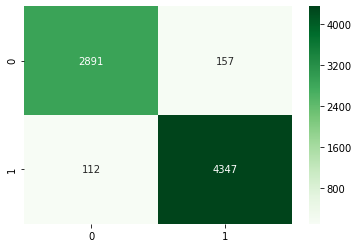

In [196]:
import seaborn as sns

cm = confusion_matrix(un_df['post_soviet'], prediction)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

<div class="alert alert-info">
<h3> Your turn</h3>
<p> In your group, do the rest of 10_Topic_Modeling_group
</div> 



